In [ ]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)


#suspress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load data

df = pd.read_csv("blood_donor_dataset.csv")
df.head(10)

,donor_id,name,email,password,contact_number,city,blood_group,availability,months_since_first_donation,number_of_donation,pints_donated,created_at
0,1b8b4c828a,Norma Fisher,ysullivan@yahoo.com,P5hX6Syg*A,+61 461706749,Hobart,A+,No,65,31,62,2017-03-17
1,a6a3f7fe55,Eugene Bowman,hramos@brown-sellers.com,b6Wq6Cqz@5,+61 450709944,Darwin,AB-,Yes,64,8,16,2016-11-11
2,cee6478144,Sheri Bolton DDS,jasmine85@hotmail.com,$9RB51m#s7,+61 428756361,Melbourne,AB+,Yes,39,6,6,2022-02-25
3,5986bc55f9,Kelly Boyd,pattylawrence@riley-hayes.com,@5Tdg(4kCm,+61 454318320,Darwin,A-,No,55,20,20,2025-04-04
4,93246afe6c,Taylor Guzman,martinezjacob@wilson.com,x!)9Ag@J*7,+61 484158472,Darwin,O-,No,7,35,35,2022-11-30
5,486ffe4e4a,Jonathan Williams,wgonzalez@harrison.com,R(2bFckq!a,+61 422518737,Hobart,A+,No,105,21,21,2015-09-16
6,32e4e74c30,Bob Stevenson,johnbenton@yahoo.com,Vs)4AhVlVd,+61 453648190,Melbourne,B-,Yes,30,9,18,2025-02-28
7,62927f7975,Amanda Savage,martincaleb@hotmail.com,p7Q#Cn$m#I,+61 422242798,Melbourne,AB-,No,13,19,38,2022-05-01
8,17a47b3f43,Jennifer Smith,bairdemma@davis.com,p%28Dpp)Qa,+61 426751810,Canberra,B-,No,56,5,10,2015-10-24
9,c6f6371120,Daniel Green,sheena09@hotmail.com,*RUVn+Ckf7,+61 452553307,Perth,AB+,Yes,24,11,11,2018-01-14


In [ ]:
# Basic preprocessing
df["created_at"] = pd.to_datetime(df["created_at"])

df["month"] = df["created_at"].dt.month


In [ ]:
df.shape


(10000, 13)

In [ ]:
df.columns


Index(['donor_id', 'name', 'email', 'password', 'contact_number', 'city',
       'blood_group', 'availability', 'months_since_first_donation',
       'number_of_donation', 'pints_donated', 'created_at', 'month'],
      dtype='object')

In [ ]:
df.nunique()


,0
donor_id,10000
name,9419
email,9954
password,10000
contact_number,9998
city,8
blood_group,8
availability,2
months_since_first_donation,121
number_of_donation,51


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.drop(
    columns=["donor_id", "email", "password", "contact_number", "created_at", "name"],
    inplace=True
)

In [ ]:
df["city"]=df["city"].astype(str)
df["blood_group"]=df["blood_group"].astype(str)
df["availability"]=df["availability"].astype(str)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   city                         10000 non-null  object
 1   blood_group                  10000 non-null  object
 2   availability                 10000 non-null  object
 3   months_since_first_donation  10000 non-null  int64 
 4   number_of_donation           10000 non-null  int64 
 5   pints_donated                10000 non-null  int64 
 6   month                        10000 non-null  int32 
dtypes: int32(1), int64(3), object(3)
memory usage: 507.9+ KB


In [ ]:
#Encode target column before one-hot encoding
df["availability"] = df["availability"].map({"Yes": 1, "No": 0})

# One-hot encode categorical features
city_freq = df["city"].value_counts(normalize=True)
df["city_freq"] = df["city"].map(city_freq)
df.drop(columns=["city"], inplace=True)
df = pd.get_dummies(df, columns=["blood_group"], drop_first=True)

In [ ]:
df.head()


,availability,months_since_first_donation,number_of_donation,pints_donated,month,city_freq,blood_group_A-,blood_group_AB+,blood_group_AB-,blood_group_B+,blood_group_B-,blood_group_O+,blood_group_O-
0,0,65,31,62,3,0.1233,False,False,False,False,False,False,False
1,1,64,8,16,11,0.1254,False,False,True,False,False,False,False
2,1,39,6,6,2,0.1241,False,True,False,False,False,False,False
3,0,55,20,20,4,0.1254,True,False,False,False,False,False,False
4,0,7,35,35,11,0.1254,False,False,False,False,False,False,True


In [ ]:
df.describe()

,availability,months_since_first_donation,number_of_donation,pints_donated,month,city_freq
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.508500,59.953100,25.128200,37.614000,6.483800,0.125050
std,0.499953,34.911379,14.654195,26.334072,3.484616,0.002487
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.119800
25%,0.000000,30.000000,12.000000,16.000000,3.000000,0.124100
50%,1.000000,60.000000,26.000000,34.000000,6.000000,0.125400
75%,1.000000,90.000000,38.000000,50.000000,10.000000,0.127200
max,1.000000,120.000000,50.000000,100.000000,12.000000,0.128300


In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [ ]:
##heatmap
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

In [ ]:
# Compute correlation matrix
corr_matrix = numeric_df.corr()

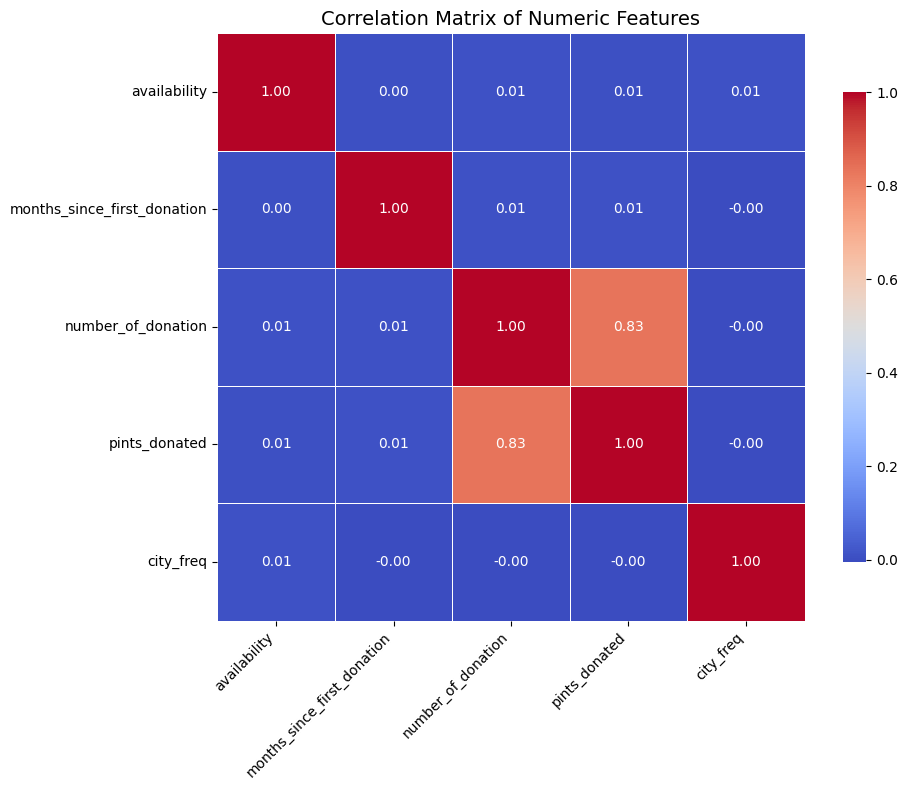

In [ ]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Numeric Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

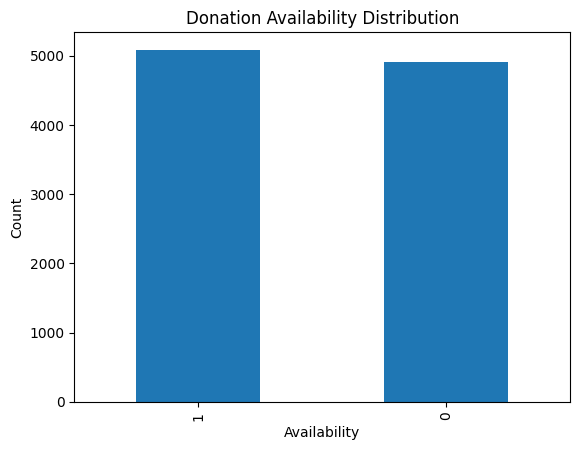

In [ ]:

# Plot: Donation Availability Distribution
target_col = "availability"
plt.figure()
df[target_col].value_counts().plot(kind="bar")
plt.title("Donation Availability Distribution")
plt.xlabel("Availability")
plt.ylabel("Count")
plt.show()
#The dataset is relatively balanced, which helps in training reliable classification models.

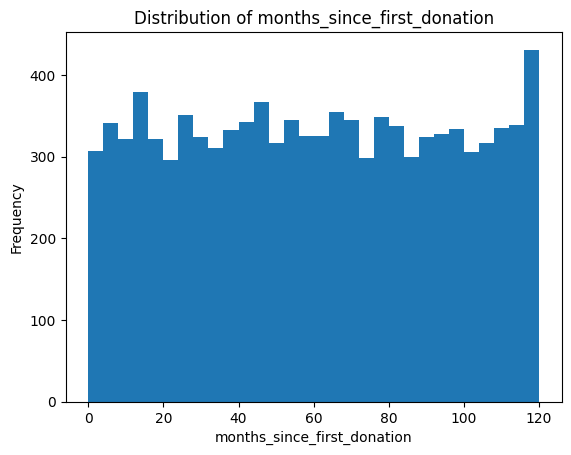

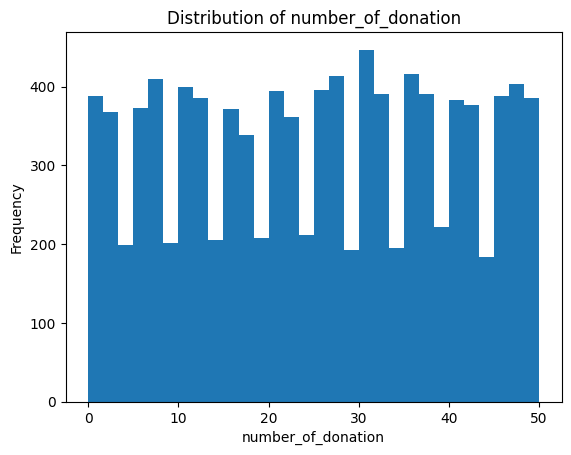

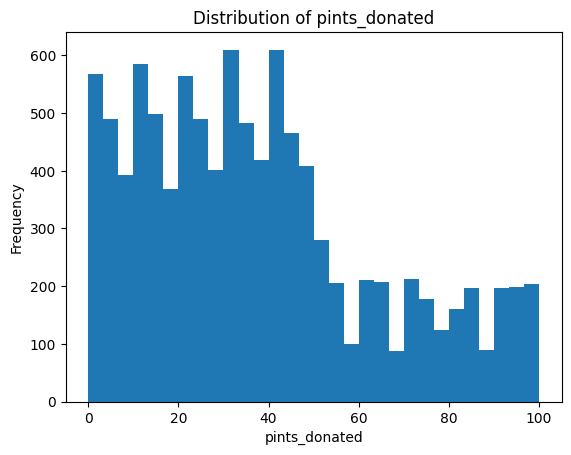

In [ ]:
# Plot: Histograms of num_cols

num_cols = [
    "months_since_first_donation",
    "number_of_donation",
    "pints_donated"
]

for col in num_cols:
    plt.figure()
    plt.hist(df[col], bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

    # Most blood donations come from individuals with a small number of previous donations.

<Figure size 640x480 with 0 Axes>

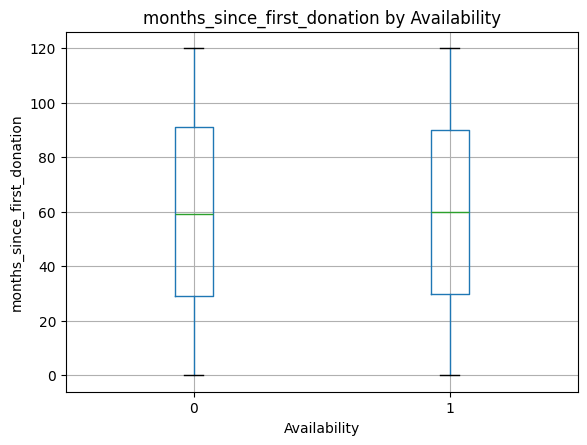

<Figure size 640x480 with 0 Axes>

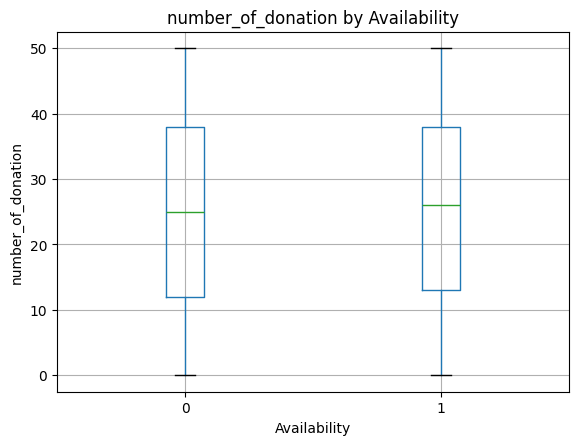

<Figure size 640x480 with 0 Axes>

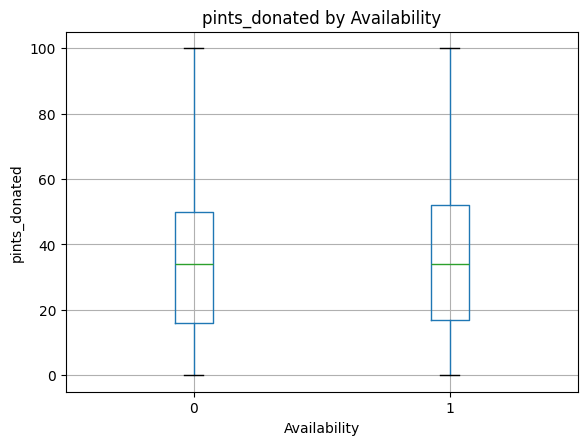

In [ ]:
# Plot: Boxplots vs Target
for col in num_cols:
    plt.figure()
    df.boxplot(column=col, by=target_col)
    plt.title(f"{col} by Availability")
    plt.suptitle("")
    plt.xlabel("Availability")
    plt.ylabel(col)
    plt.show()
    #Available donors show a higher number of previous blood donations.

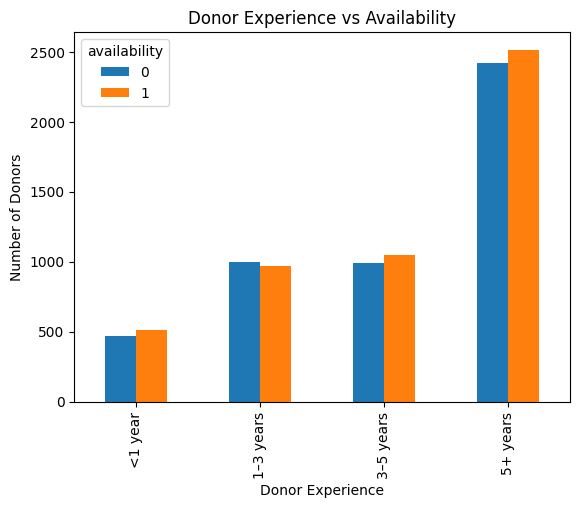

In [ ]:
# Plot: Donation Frequency vs Donated (Availability)
df["donor_experience"] = pd.cut(
    df["months_since_first_donation"],
    bins=[0, 12, 36, 60, 120],
    labels=["<1 year", "1–3 years", "3–5 years", "5+ years"]
)

# We count how many donors exist in each category.
counts = df.groupby(["donor_experience", "availability"]).size()

# We convert the data to table format
counts.unstack().plot(kind="bar")

plt.title("Donor Experience vs Availability")
plt.xlabel("Donor Experience")
plt.ylabel("Number of Donors")
plt.show()
# Donors with greater blood donation experience show increased availability,
# indicating that long-term participation enhances the likelihood of future blood donation. In contrast, newer donors show lower availability levels.

In [ ]:
df.drop(
    columns=["donor_experience"],
    inplace=True
)

In [ ]:
# Train the model
# Train-test split



In [ ]:
# Define target variable and features
X = df.drop(columns=['availability'])
y = df['availability']
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y #διατηρείς την αναλογία των κλάσεων
)

In [ ]:
# BASELINE (no feature engineering)

In [ ]:
results_before = {}

def evaluate_model_dict(name, model, X_test, y_test, store_dict):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    store_dict[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }

In [ ]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
evaluate_model_dict("RF", rf, X_test, y_test, results_before)

In [ ]:
# XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)
evaluate_model_dict("XGB", xgb, X_test, y_test, results_before)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Logistic Regression
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
log_reg.fit(X_train, y_train)
evaluate_model_dict("LogReg", log_reg, X_test, y_test, results_before)

In [ ]:
# SVM
svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=1, gamma="scale", probability=True))
])

svm.fit(X_train, y_train)
evaluate_model_dict("SVM", svm, X_test, y_test, results_before)

In [ ]:
before_df = pd.DataFrame(results_before).T
before_df

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
RF,0.4905,0.499136,0.568338,0.531494,0.480095
XGB,0.4680,0.477683,0.494592,0.485990,0.471592
LogReg,0.4900,0.498581,0.518191,0.508197,0.488675
SVM,0.4955,0.503490,0.567355,0.533518,0.488073


In [ ]:
# Feature Engineering (NO DATA LEAKAGE)

def feature_engineering(df):
    df = df.copy()

    df["avg_donation_interval"] = np.where(
        df["number_of_donation"] > 0,
        df["months_since_first_donation"] / df["number_of_donation"],
        0
    )

    df["donation_intensity"] = np.where(
        (df["number_of_donation"] > 0) & (df["months_since_first_donation"] > 0),
        df["number_of_donation"] / (df["months_since_first_donation"] / 12),
        0
    )
    return df
#Donation intensity -πόσες δωρεές ανά έτος
#👉 πολύ πιο ρεαλιστικός δείκτης “ενεργού δότη”
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

In [ ]:
results_after = {}
def evaluate_model_dict(name, model, X_test, y_test, store_dict):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    store_dict[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }

In [ ]:


rf.fit(X_train, y_train)
evaluate_model_dict("RF", rf, X_test, y_test, results_after)

xgb.fit(X_train, y_train)
evaluate_model_dict("XGB", xgb, X_test, y_test, results_after)

log_reg.fit(X_train, y_train)
evaluate_model_dict("LogReg", log_reg, X_test, y_test, results_after)

svm.fit(X_train, y_train)
evaluate_model_dict("SVM", svm, X_test, y_test, results_after)

after_df = pd.DataFrame(results_after).T
after_df


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
LogReg,0.4895,0.498051,0.502458,0.500245,0.491513
RF,0.4900,0.498704,0.567355,0.530819,0.475274
XGB,0.4835,0.492110,0.490659,0.491384,0.477610
SVM,0.4995,0.507168,0.556539,0.530708,0.485933


In [ ]:


comparison = after_df - before_df
comparison

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
LogReg,-0.0005,-0.000530,-0.015733,-0.007952,0.002838
RF,-0.0005,-0.000433,-0.000983,-0.000675,-0.004820
SVM,0.0040,0.003678,-0.010816,-0.002810,-0.000823
XGB,0.0155,0.014428,-0.003933,0.005393,0.006018
